Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_1, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: conv1_bn, Layer Type: BatchNormalization
Index: 4, Layer Name: conv1_relu, Layer Type: Activation
Index: 5, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 6, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 11, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 12, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 13, Layer Name: conv2_block1_0_conv, Layer Type: Conv2D
Index: 14, Layer Name: conv2_block1_3_conv,

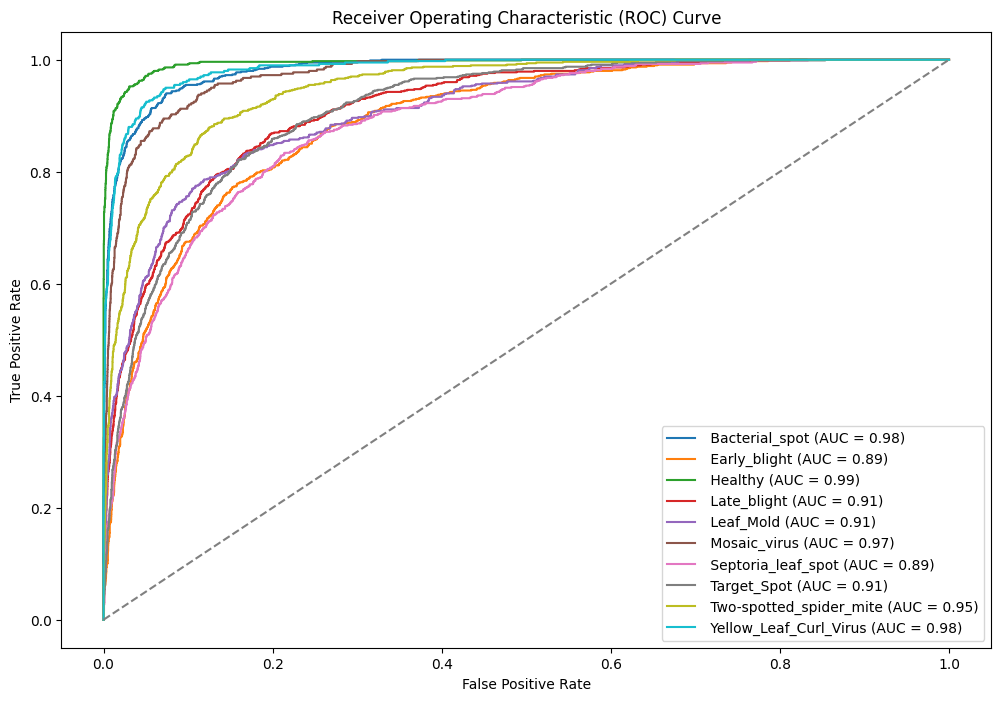

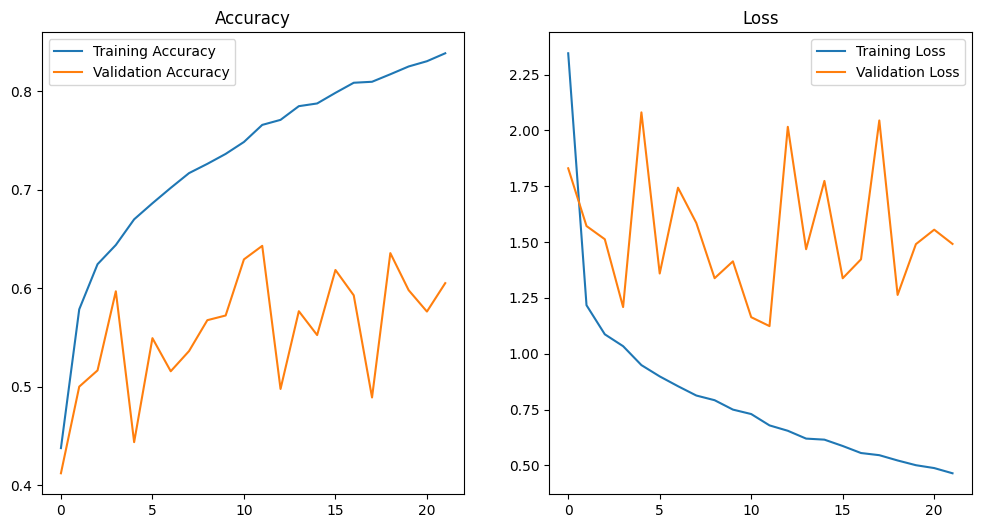

84/84 [==============================] - 23s 266ms/step - loss: 1.1236 - accuracy: 0.6431
Final Validation Accuracy: 0.6431
Final Validation Loss: 1.1236
84/84 [==============================] - 24s 279ms/step
Confusion Matrix:
[[549  24   6  21  13   2  10   5   1 169]
 [  8 337   2  79 166   5  29  65  21  88]
 [  0   1 708   0   3   2  11  66   5   4]
 [  9  61   6 373 181  33  40  51   6  40]
 [  0  45   1  15 591  27  19  30  10  62]
 [  0   4   6   0  62 644   2  18  10  54]
 [ 24  70  20  47 173  45 274  68  17  62]
 [  1  29  23  17  69  18  37 476  75  55]
 [  0  12   8   4  56  79  11 114 433  83]
 [  6   0   0   4   4  18   0   4   4 760]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       800
           1       0.58      0.42      0.49       800
           2       0.91      0.89      0.90       800
           3       0.67      0.47      0.55       800
           4       0.45      0.74      0.56    

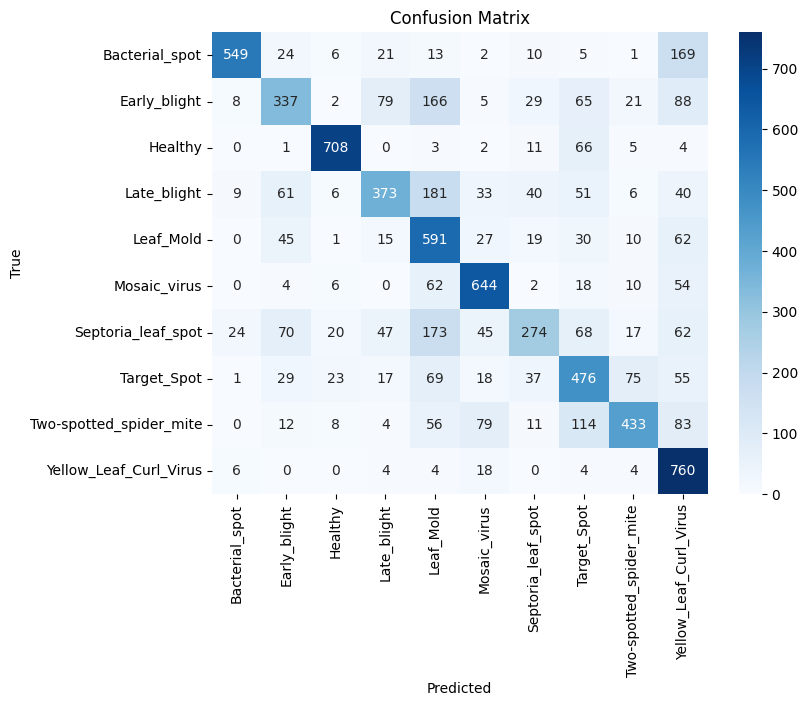

In [1]:
#ResNet50
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10
# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet50.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet50.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_1, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 4, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 5, Layer Name: conv2_block1_preact_bn, Layer Type: BatchNormalization
Index: 6, Layer Name: conv2_block1_preact_relu, Layer Type: Activation
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_pad, Layer Type: ZeroPadding2D
Index: 11, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 12, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 13, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 14

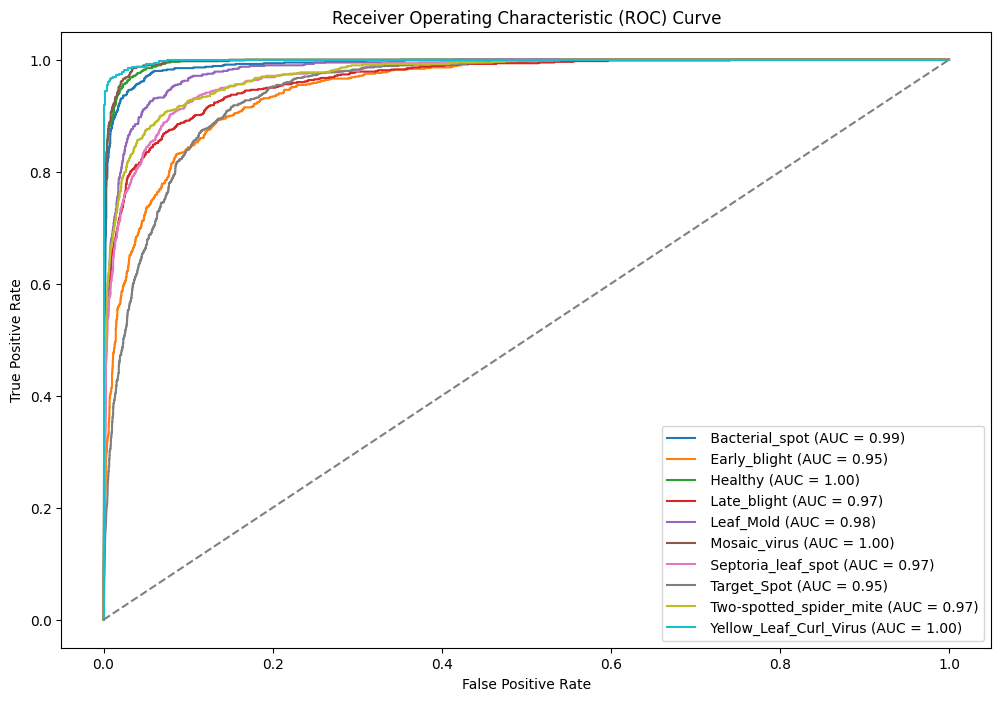

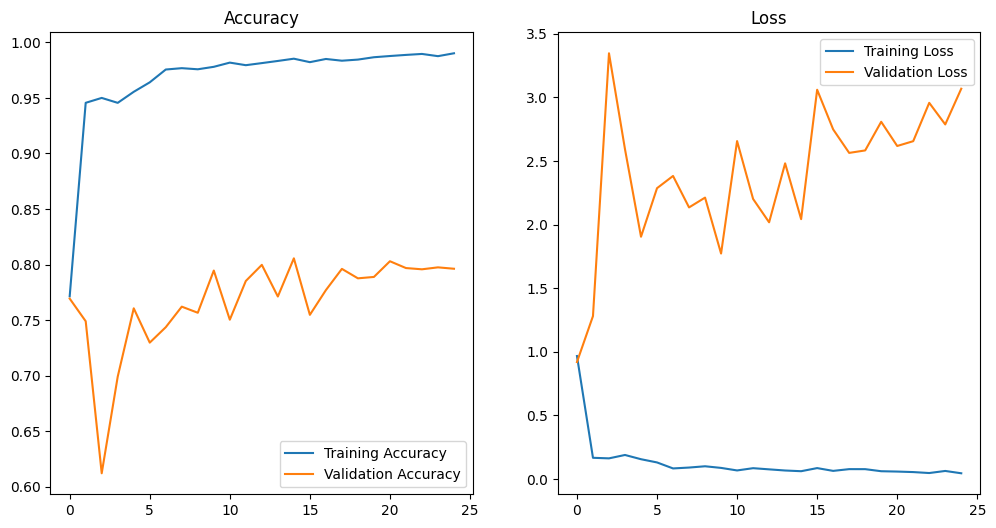

84/84 [==============================] - 22s 262ms/step - loss: 2.0430 - accuracy: 0.8056
Final Validation Accuracy: 0.8056
Final Validation Loss: 2.0430
84/84 [==============================] - 24s 287ms/step
Confusion Matrix:
[[737   7   0   7   4   0  30   9   2   4]
 [ 47 452  13  89  30   3  51  80  31   4]
 [  1   4 759   0   0   4   5  14  12   1]
 [ 11  46  10 607  42   4  40  25  13   2]
 [  1  26  12  23 652  27  22  16  18   3]
 [  2   0  10   0  24 729   7   6  22   0]
 [ 32  33  10  30  21   9 619  31  15   0]
 [ 29  20  77  22  21   1  40 469 119   2]
 [  3   7  11   6  12  17  18  58 665   3]
 [ 12   0   4   6   4   6   4   4   4 756]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       800
           1       0.76      0.56      0.65       800
           2       0.84      0.95      0.89       800
           3       0.77      0.76      0.76       800
           4       0.80      0.81      0.81    

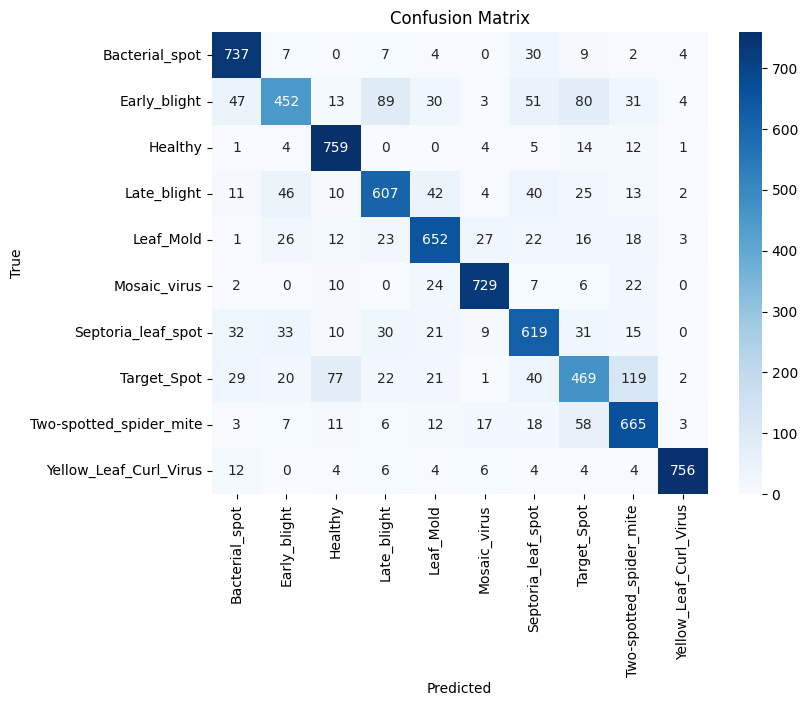

In [1]:
#ResNet50V2
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10
# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet50v2.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet50V2.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_2, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: conv1_bn, Layer Type: BatchNormalization
Index: 4, Layer Name: conv1_relu, Layer Type: Activation
Index: 5, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 6, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 11, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 12, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 13, Layer Name: conv2_block1_0_conv, Layer Type: Conv2D
Index: 14, Layer Name: conv2_block1_3_conv,

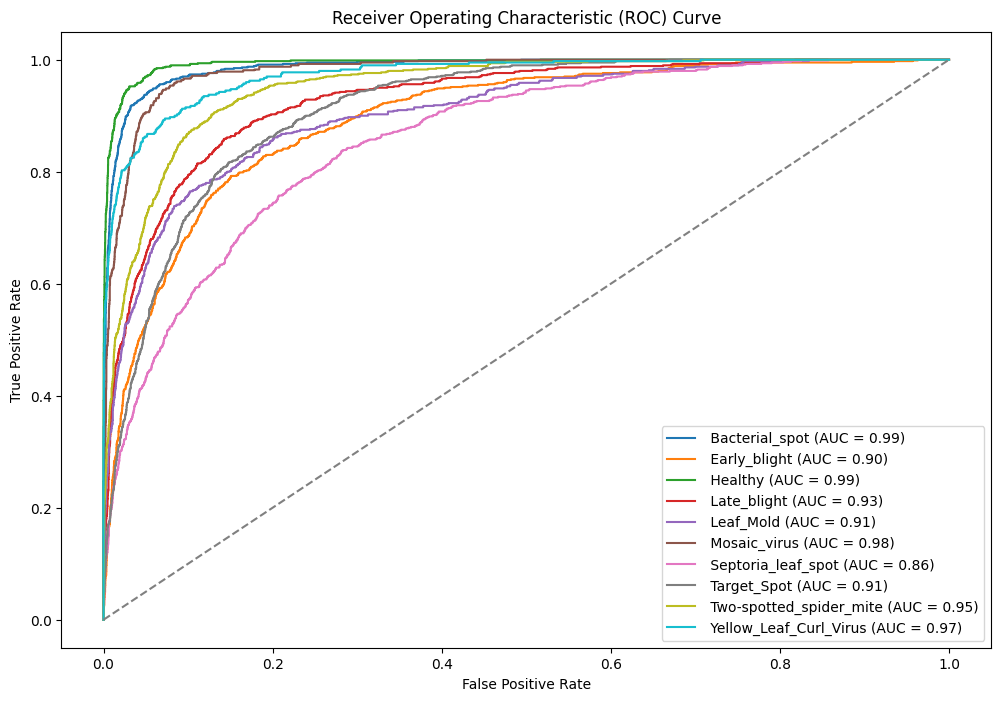

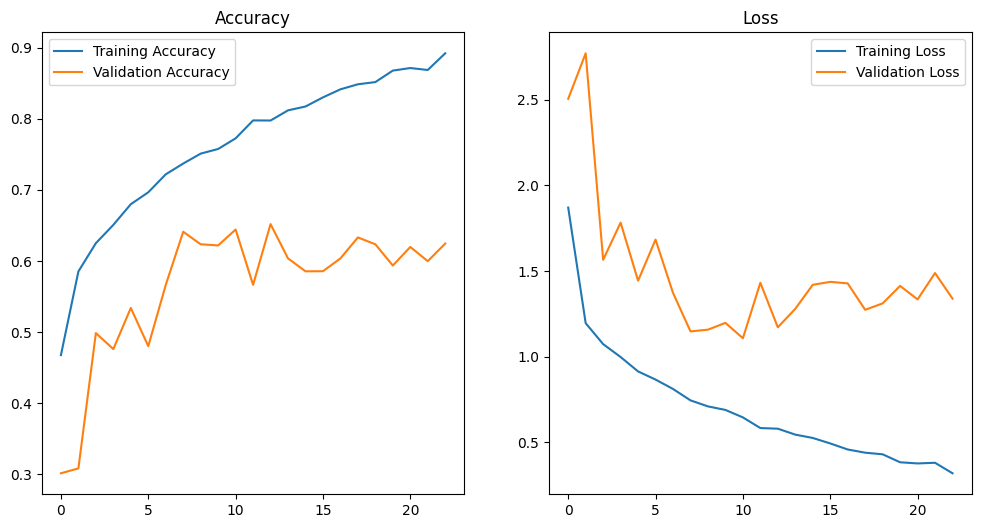

84/84 [==============================] - 22s 254ms/step - loss: 1.1715 - accuracy: 0.6519
Final Validation Accuracy: 0.6519
Final Validation Loss: 1.1715
84/84 [==============================] - 22s 255ms/step
Confusion Matrix:
[[668  33   0  32   3   6   4   1   2  51]
 [ 26 465   3 152  29  13  11  21  49  31]
 [  4   6 684   7   1  14   8  33  43   0]
 [ 10  73   4 562  34  37  15  23  28  14]
 [  1 141   6  78 364  96   6   4  55  49]
 [  0  15   2   0   6 727   2   4  36   8]
 [ 52 106   8 164  48 100 175  33  90  24]
 [ 15  85  42  47   8  38  31 256 274   4]
 [  0  31   4   8   5  45   1  31 674   1]
 [ 12  24   4   6   8  32   4   0  70 640]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       800
           1       0.47      0.58      0.52       800
           2       0.90      0.85      0.88       800
           3       0.53      0.70      0.61       800
           4       0.72      0.46      0.56    

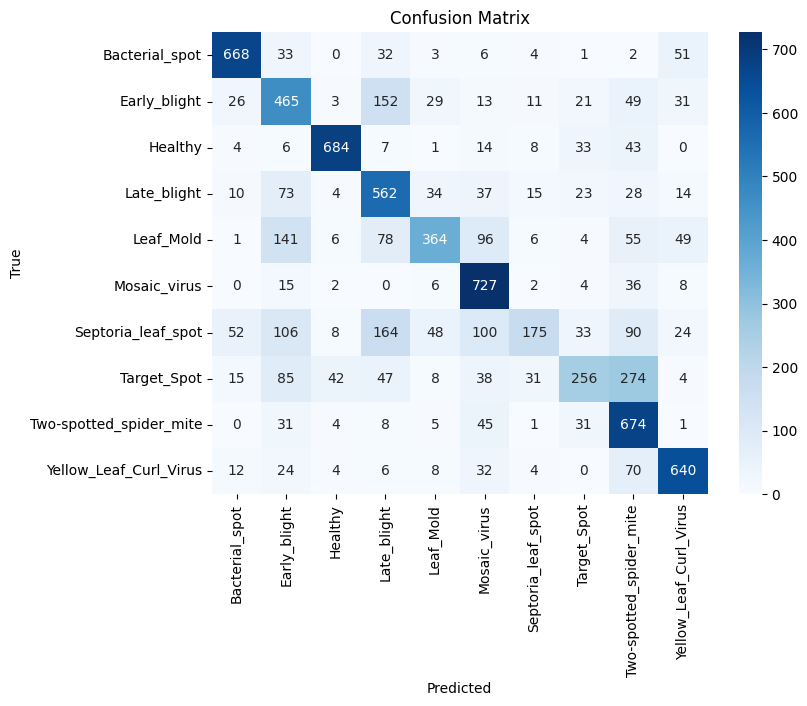

In [2]:
#ResNet101
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet101(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet101.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet101.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_3, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 4, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 5, Layer Name: conv2_block1_preact_bn, Layer Type: BatchNormalization
Index: 6, Layer Name: conv2_block1_preact_relu, Layer Type: Activation
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_pad, Layer Type: ZeroPadding2D
Index: 11, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 12, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 13, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 14

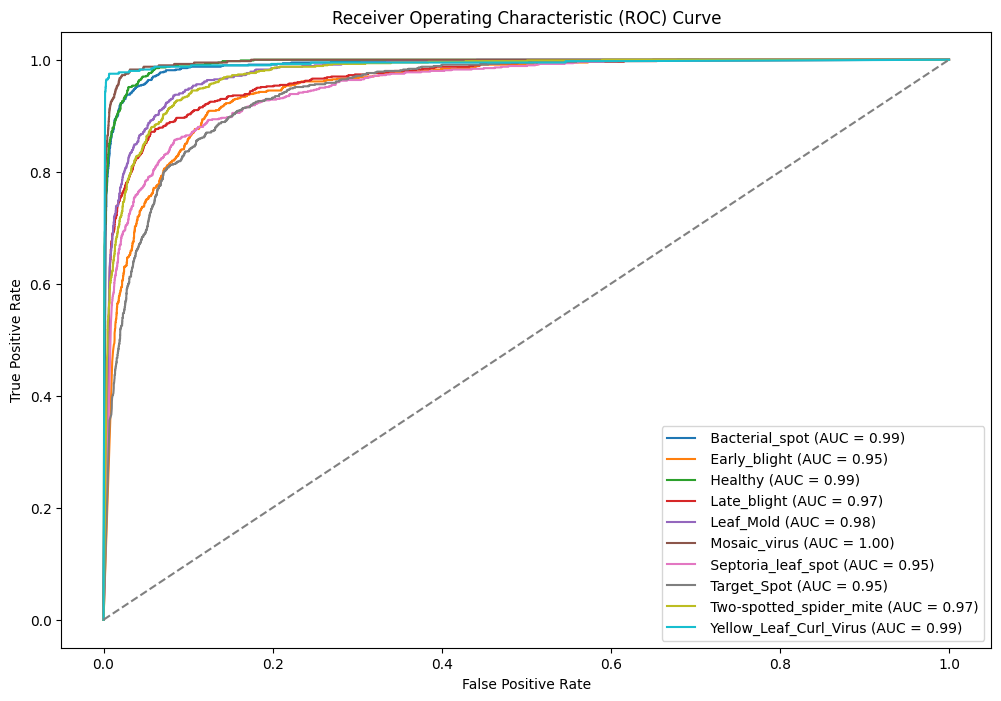

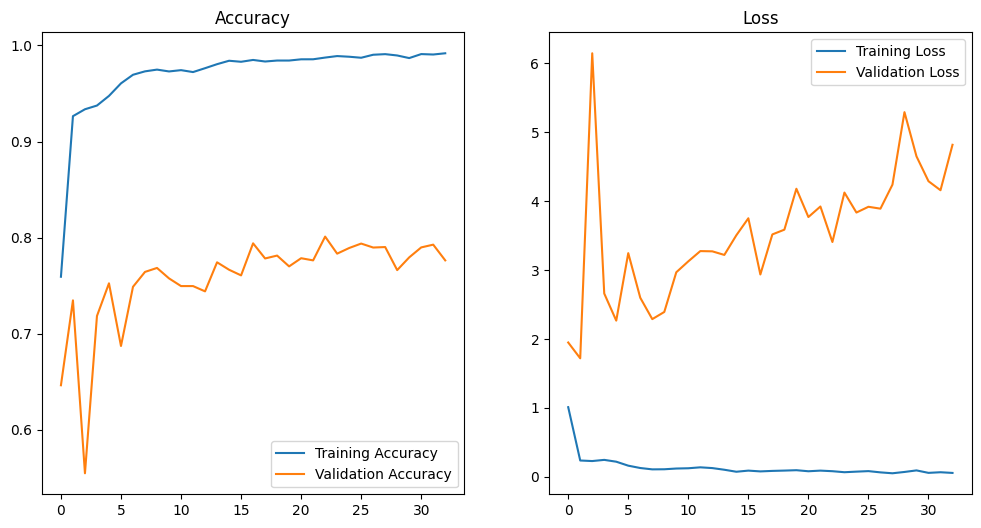

84/84 [==============================] - 22s 253ms/step - loss: 3.4059 - accuracy: 0.8010
Final Validation Accuracy: 0.8010
Final Validation Loss: 3.4059
84/84 [==============================] - 22s 261ms/step
Confusion Matrix:
[[681  31   0  20   4   2  40   9   1  12]
 [ 18 576   1  51  46   2  49  44  13   0]
 [  0   8 663   5   7   6  24  74  12   1]
 [  7  73   7 624  29   0  43  12   1   4]
 [  3  29   2  37 639  22  35  11  17   5]
 [  0  10   2   2  18 740   0   6  12  10]
 [ 19  67   3  31  34   8 607  18  12   1]
 [ 11  57  12  35  23   6  53 528  70   5]
 [  1  18  10  16  16  16  32 107 570  14]
 [  2   4   2   0   2   4   0   6   0 780]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       800
           1       0.66      0.72      0.69       800
           2       0.94      0.83      0.88       800
           3       0.76      0.78      0.77       800
           4       0.78      0.80      0.79    

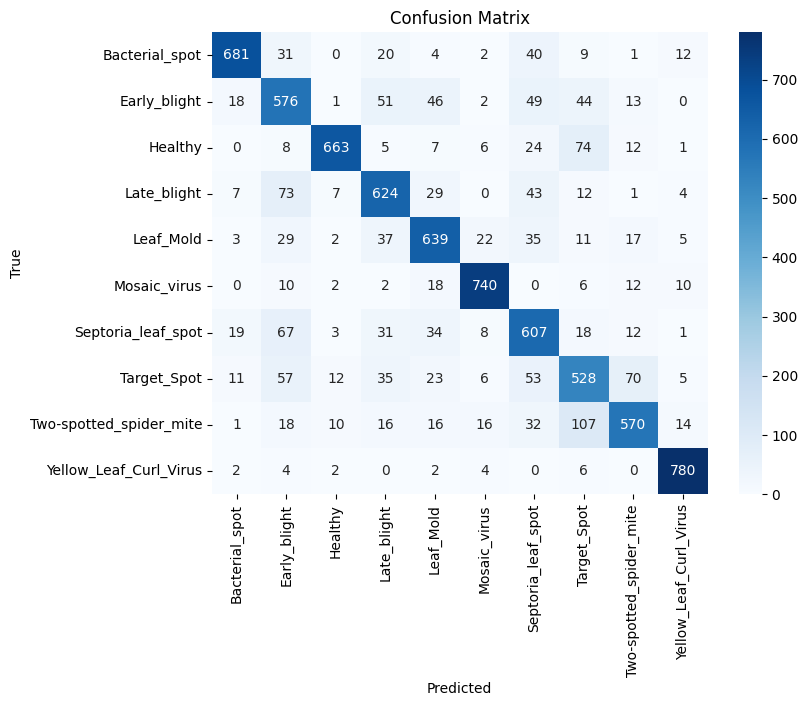

In [3]:
#ResNet101V2
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet101V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet101V2.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet101V2.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_4, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: conv1_bn, Layer Type: BatchNormalization
Index: 4, Layer Name: conv1_relu, Layer Type: Activation
Index: 5, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 6, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 11, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 12, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 13, Layer Name: conv2_block1_0_conv, Layer Type: Conv2D
Index: 14, Layer Name: conv2_block1_3_conv,

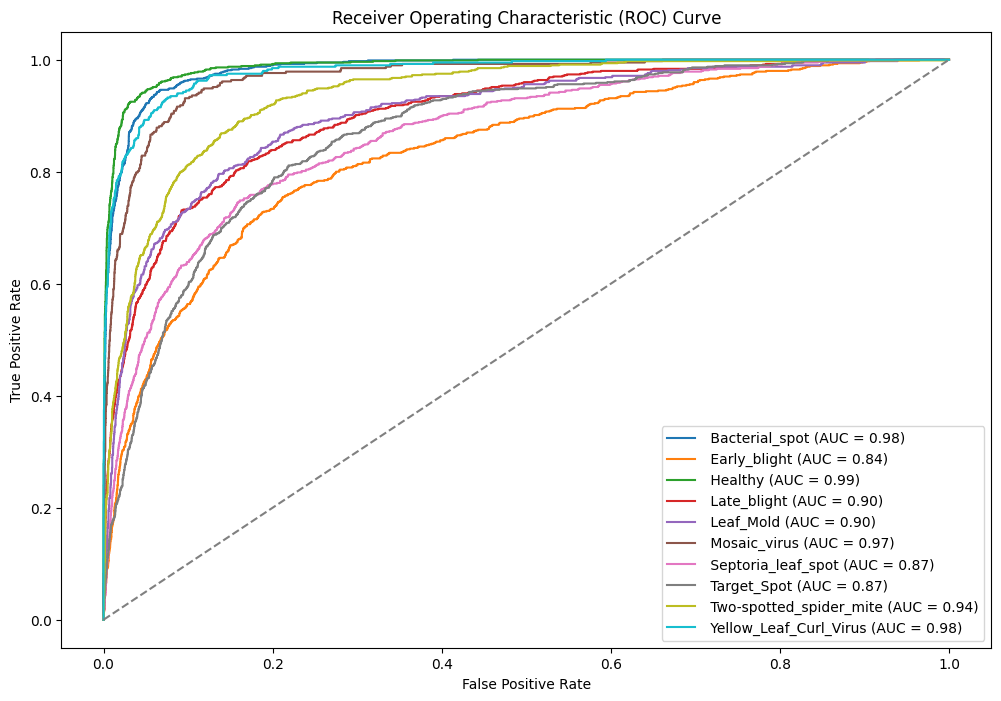

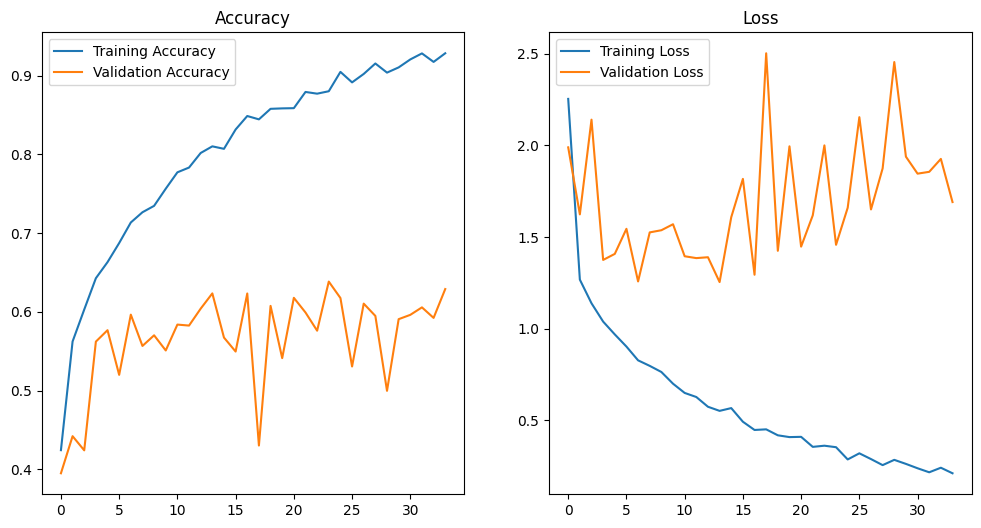

84/84 [==============================] - 43s 503ms/step - loss: 1.4571 - accuracy: 0.6385
Final Validation Accuracy: 0.6385
Final Validation Loss: 1.4571
84/84 [==============================] - 41s 488ms/step
Confusion Matrix:
[[708  15   2  22   4   1   4   1   3  40]
 [ 54 295   9 140  76   5  46  76  65  34]
 [  3   1 726   6   6   1   1  31  25   0]
 [ 49  42  10 480  78   5  50  47  30   9]
 [ 17  71   6  57 513  27  19  23  42  25]
 [  2  16  22  12  68 531  16  13 104  16]
 [ 83  54  21  85  87  33 295  71  56  15]
 [ 22  49  89  38  34  11  25 317 208   7]
 [  5  16  30  14  13  29  11  71 601  10]
 [ 34  24   0   6  20  18   8  10  38 642]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       800
           1       0.51      0.37      0.43       800
           2       0.79      0.91      0.85       800
           3       0.56      0.60      0.58       800
           4       0.57      0.64      0.60    

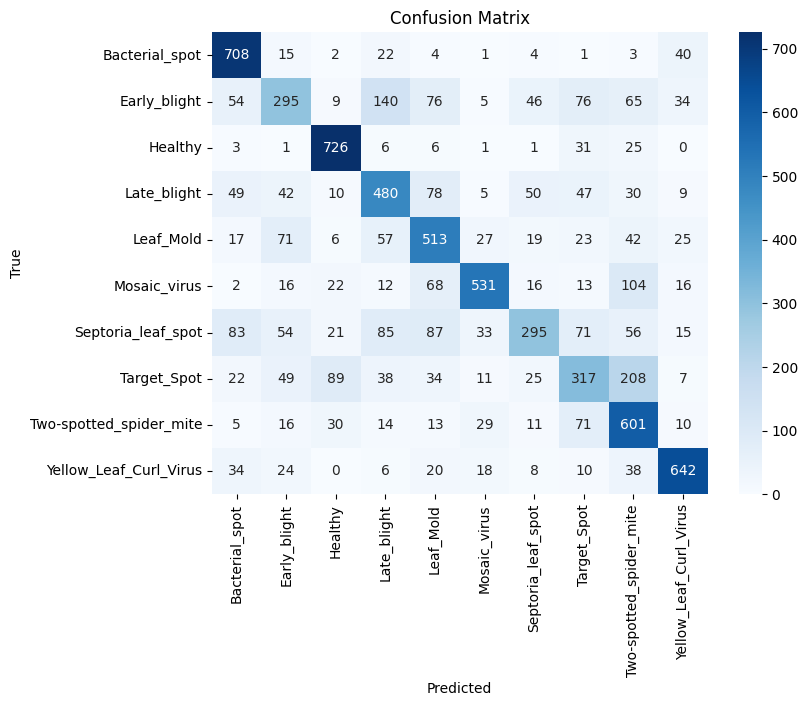

In [4]:
#ResNet152
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet152(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet152.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet152.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Index: 0, Layer Name: input_5, Layer Type: InputLayer
Index: 1, Layer Name: conv1_pad, Layer Type: ZeroPadding2D
Index: 2, Layer Name: conv1_conv, Layer Type: Conv2D
Index: 3, Layer Name: pool1_pad, Layer Type: ZeroPadding2D
Index: 4, Layer Name: pool1_pool, Layer Type: MaxPooling2D
Index: 5, Layer Name: conv2_block1_preact_bn, Layer Type: BatchNormalization
Index: 6, Layer Name: conv2_block1_preact_relu, Layer Type: Activation
Index: 7, Layer Name: conv2_block1_1_conv, Layer Type: Conv2D
Index: 8, Layer Name: conv2_block1_1_bn, Layer Type: BatchNormalization
Index: 9, Layer Name: conv2_block1_1_relu, Layer Type: Activation
Index: 10, Layer Name: conv2_block1_2_pad, Layer Type: ZeroPadding2D
Index: 11, Layer Name: conv2_block1_2_conv, Layer Type: Conv2D
Index: 12, Layer Name: conv2_block1_2_bn, Layer Type: BatchNormalization
Index: 13, Layer Name: conv2_block1_2_relu, Layer Type: Activation
Index: 14

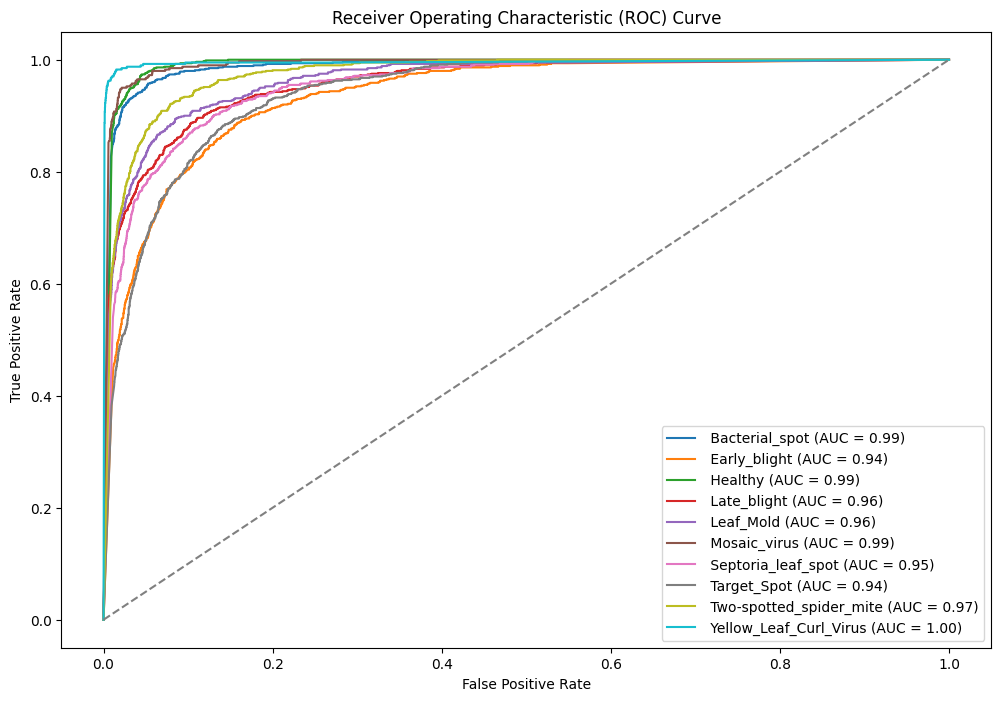

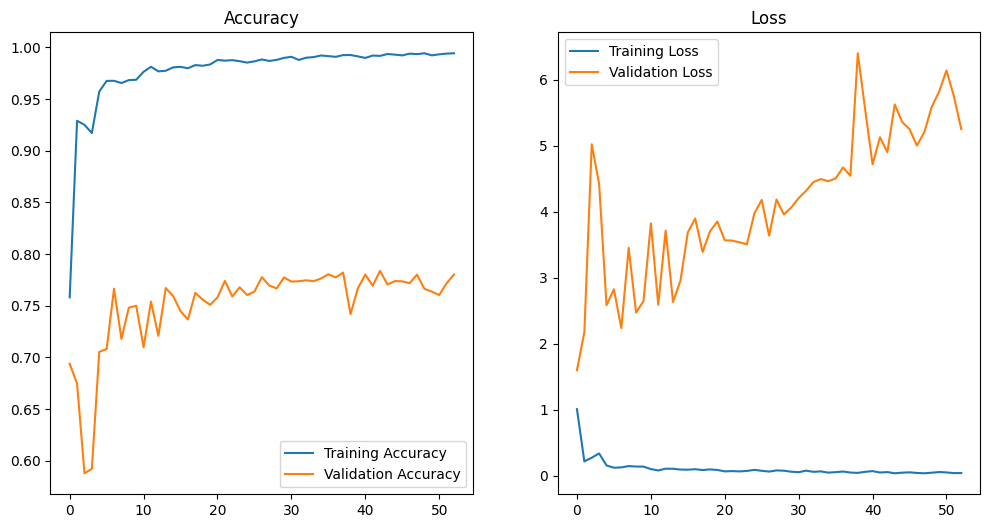

84/84 [==============================] - 37s 424ms/step - loss: 4.9047 - accuracy: 0.7836
Final Validation Accuracy: 0.7836
Final Validation Loss: 4.9047
84/84 [==============================] - 35s 419ms/step
Confusion Matrix:
[[732  12   0  11   3   1  20  10   2   9]
 [ 52 496  16  55  38   7  48  63  21   4]
 [  0   0 749   0   1   4   9  26  11   0]
 [ 16  81  16 560  41   6  54  20   5   1]
 [  8  50  11  29 578  42  31  33  16   2]
 [  0   2  14   2  24 734  12   2  10   0]
 [ 48  57   6  25  27   6 575  30  22   4]
 [ 31  42  80   8  13   8  48 496  72   2]
 [  3   8  45   8   9  24  13  93 597   0]
 [  4   6   6   2   0  16   0   6   8 752]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       800
           1       0.66      0.62      0.64       800
           2       0.79      0.94      0.86       800
           3       0.80      0.70      0.75       800
           4       0.79      0.72      0.75    

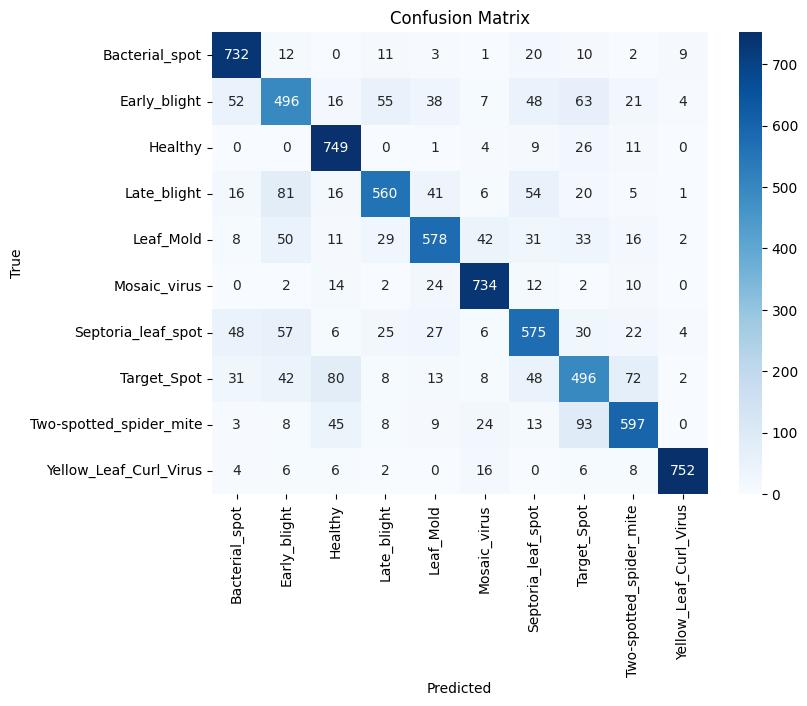

In [5]:
#ResNet152V2
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Dataset and Parameters
dataset_dir ="./Tomato"
img_size = (224, 224)
batch_size = 96
num_classes = 10

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(
    dataset_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False)

# Load ResNet50 model without the top layer
base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Print ResNet50 layers
for idx, layer in enumerate(base_model.layers):
    print(f"Index: {idx}, Layer Name: {layer.name}, Layer Type: {layer.__class__.__name__}")

# Add custom classification head
flattened = Flatten()(base_model.output)
output = Dense(num_classes, activation="softmax")(flattened)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("./best_model_resnet152V2.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stop, model_checkpoint]

# Training
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=callbacks)
model.save("./Resnet152V2.h5")
print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# ROC Curve
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))

fpr = {}
tpr_stage1 = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr[i], tpr_stage1[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr_stage1[i])
    plt.plot(fpr[i], tpr_stage1[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate the Final Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix and Report
y_pred = model.predict(val_generator, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(conf_matrix, class_labels)